### Plot temperature and humidity data

In [5]:
from datetime import datetime
from datetime import timedelta
import numpy as np
data_N = 1 # smoothing factor for data reading
def read_data(file_path):
    trace = []
    with open(file_path, 'r') as f:
        # extract start time from start time
        first_line = f.readline()
        data = first_line.strip().split(',')
        start_time = datetime.strptime(data[0], '%H:%M:%S.%f')
        last_time = start_time
        negFlag = False # use a flag to avoid loops
        breakFlag = False

        while True:
            buf = []
            for i in range(0, data_N):
                line = f.readline()
                data = line.strip().split(',')
                cur_time = datetime.strptime(data[0], '%H:%M:%S.%f')
                # elapsed time in hours
                elapsed_time_h = (cur_time - start_time).total_seconds() / 3600
                
                if elapsed_time_h < 0:
                    # add another day to avoid negative elapsed time
                    negFlag = True
                    elapsed_time_h += 24
                elif negFlag == True and elapsed_time_h > 0:
                    # finish processing all the data, end the loop
                    breakFlag = True
                    break

                # process voltage, current and power data
                temp = int(data[5])
                humid = int(data[6])
                buf.append([elapsed_time_h, temp, humid])
                
            # use the average
            if len(buf) != 0: # buf is not empty
                buf = np.array(buf)
                trace.append(np.mean(buf, axis=0))
            
            if breakFlag:
                break
    return np.array(trace)

AttributeError: module 'matplotlib.pyplot' has no attribute 'savfig'

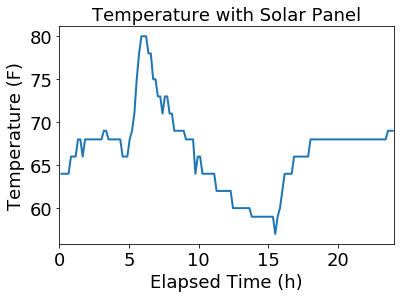

In [6]:
import matplotlib.pyplot as plt
def plot(x, y, ylabel, title, fname):
    plt.figure()
    plt.plot(x, y, linewidth=2.0)
    plt.xlim((0, 24))
    plt.xlabel('Elapsed Time (h)', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.tick_params(labelsize=18)
    plt.title(title, fontsize=18)
    plt.savfig(fname, dpi=300)

data_solar = read_data('./data/recv_data_solar.txt')
data_bat = read_data('./data/recv_data_bat.txt')

plot(data_solar[:, 0], data_solar[:, 1], 'Temperature (F)', 'Temperature with Solar Panel', 'temp_solar.png')
plot(data_solar[:, 0], data_solar[:, 2], 'Humidity (\%)', 'Humidity with Solar Panel', 'humid_solar.png')
plot(data_bat[:, 0], data_bat[:, 1], 'Temperature (F)', 'Temperature with Battery', 'temp_bat.png')
plot(data_bat[:, 0], data_bat[:, 2], 'Humidity (\%)', 'Humidity without Solar Panel', 'humid_bat.png')